# Getting started with AudioSeal

This notebook shows a minimal example to get started with AudioSeal. Make sure you install the package from PyPi or from source in editable mode beforehand.

First, let's prepare some example audios into the proper Tensor format using Torchaudio

In [1]:
%%capture

# For the demonstration, we need torchaudio and matplotlib to process example audios and visualize the spectrogram
import sys
!{sys.executable} -m pip install torchaudio soundfile matplotlib

In [2]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())
    
    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()
print(audio.shape, sr)

torch.Size([1, 167226]) 22050


(Quick check of the original content and spectrogram)

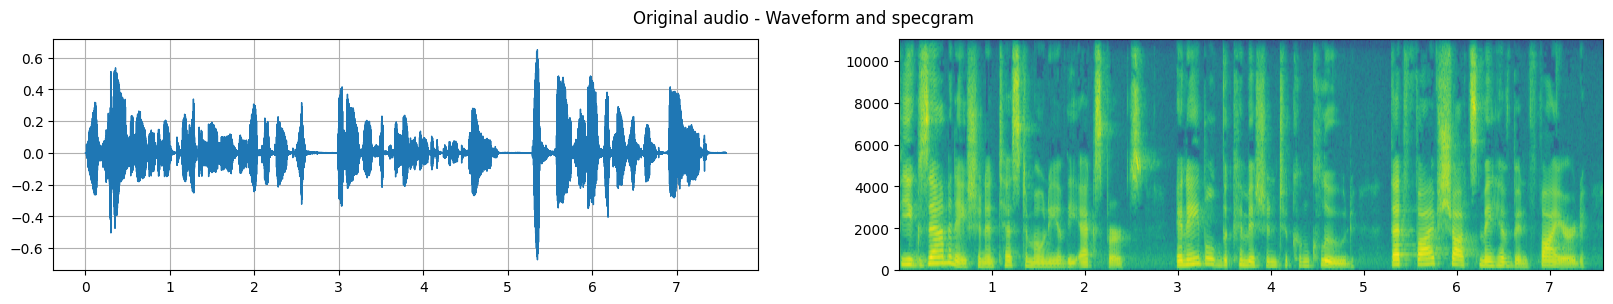

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from notebook import play_audio, plot_waveform_and_specgram, plot_waveform_and_melspec

plot_waveform_and_specgram(audio, sr, title="Original audio")
# plot_waveform_and_melspec(audio, sr, title="Original audio")

In [4]:
play_audio(audio, sr)

## Generator

To watermark an audio, we simply load the watermarking generator from the hub:

In [5]:
from audioseal import AudioSeal

model = AudioSeal.load_generator("audioseal_wm_16bits")

# We add the batch dimension to the single audio to mimic the batch watermarking
audios = audio.unsqueeze(0)

watermark = model.get_watermark(audios, sample_rate=sr)
watermarked_audio = audios + watermark

# Alternatively, you can also call forward() function directly with different tune-down / tune-up rate
watermarked_audio = model(audios, sample_rate=sr, alpha=1)

In [8]:
audios.shape

torch.Size([1, 1, 167226])

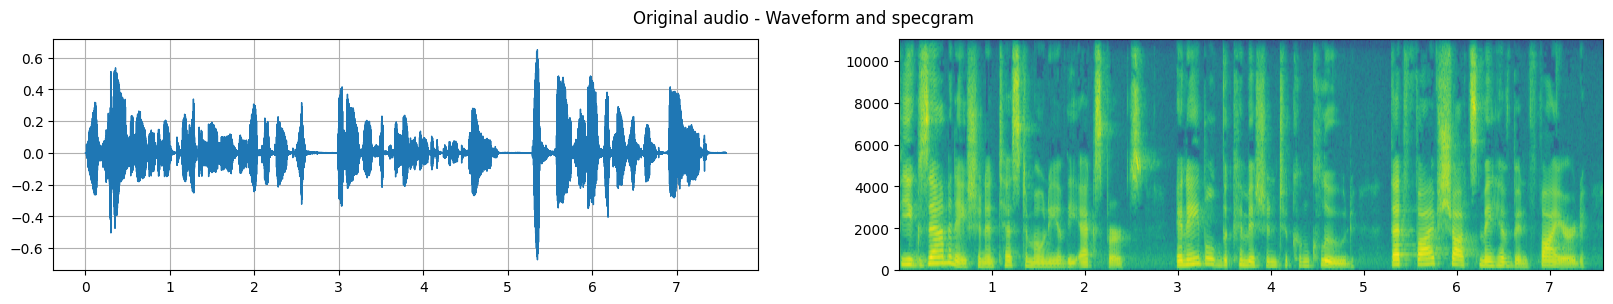

In [6]:
plot_waveform_and_specgram(audios.squeeze(), sr, title="Original audio")

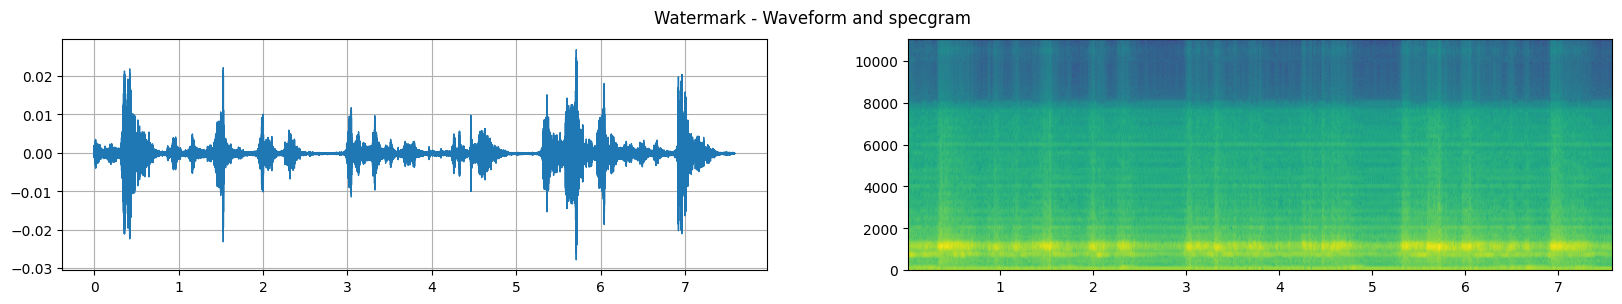

In [7]:
plot_waveform_and_specgram(watermark.squeeze(), sr, title="Watermark")

In [9]:
play_audio(watermark, sr)

We can see that the watermarked audio has preserved almost the same spectrogram and contents as the original one

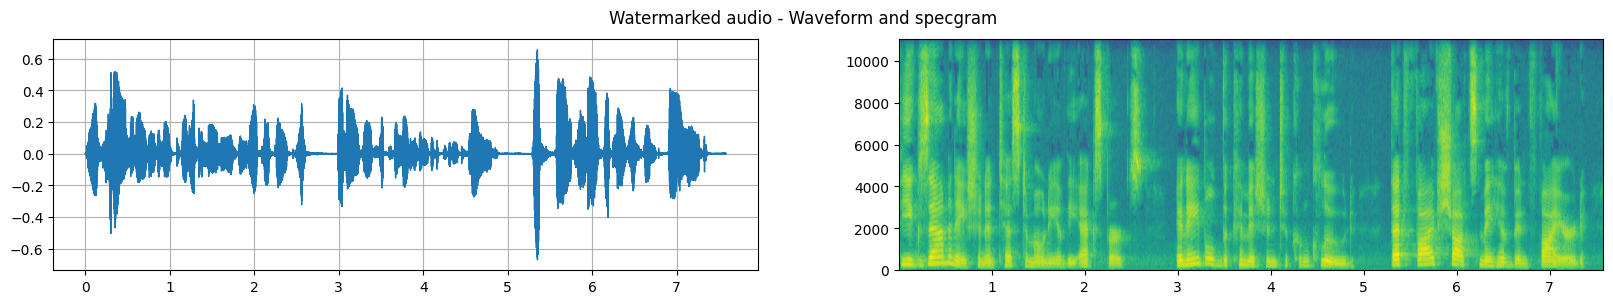

In [10]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Watermarked audio")

In [11]:
play_audio(watermarked_audio, sr)

### Watermarking with a secret message:

AudioSeal uses a secret message to generate a watermarking, which consists of <i>n</i> binary bits (n=16 for the above model, hence the model name). By default, if the user does not specify these n bits, a random message will be generated. This can be customized either by assigning the secret message before the watermarking process:

```
`model.message = <n bit Tensor>`
``` 

or by executing the model each time with one explicit secret message:

```
watermark = model(audio, message=<message>)
```

In [12]:
secret_mesage = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_mesage

tensor([[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]], dtype=torch.int32)

In [13]:
watermarked_audio = model(audios, sample_rate=sr, message=secret_mesage, alpha=1)

## Detector

To detect the watermarks from an audio, we load the separate detector model and can do one of the following:

### Basic usage: Call `detect_watermark()`
This results in a tuple of form `Tuple(float, Tensor)`, where the first value indicates the probability of the audio being watermarked (the higher, the more likely), and the second value is the decoded message that is embeded by the generator. If the audio is unwatermarked (low first value), the decoded message will be just some random bits.

Note that due to the stochastic nature of the detector, the decoded message and the secret message might miss by 1 bit, so depending on the user's need, the detection might be called multiple times to get an averaged decoded message.

In [14]:
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))

result, message = detector.detect_watermark(watermarked_audio, sample_rate=sr, message_threshold=0.5)

print(f"\nThis is likely a watermarked audio: {result}")

# Run on an unwatermarked audio
result2, message2 = detector.detect_watermark(audios, sample_rate=sr, message_threshold=0.5)
print(f"This is likely an unwatermarked audio: {result2}")



This is likely a watermarked audio: 1.0
This is likely an unwatermarked audio: 3.296440627309494e-05


In [15]:
message, message2

(tensor([[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]], dtype=torch.int32),
 tensor([[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]], dtype=torch.int32))

`message_threshold` indicates the threshold in which the detector will convert the stochastic messages (with probability between 0 and 1) into the n-bit binary format. In most of the case, the generator generates an unbiased message from the secret, so `0.5` is a reasonable choice (so in the above example, value > 0.5 means 1 and value < 0.5 means 0). 


#### Advanced usage: Call `forward()`

The detector can also be called directly as a Torch module. This will return 2 tensors: 
- The first tensor of size `batch x 2 x frames` indicates the probability of each frame being watermarked (positive or negative). So t[:, 0, :] corresponds to the negative probability and t[:, 1, :] corresponds to the positive probability
- The second tensor of size `batch x n_bits` corresponds to the message detected from the audio. It indicates the probability for each bit to be 1. In case of unwatermarked audios, this tensor is random

In [16]:
pred_prob, message_prob = detector(watermarked_audio, sample_rate=sr)
print(pred_prob[:, 1, :])

tensor([[0.9995, 0.9995, 0.9995,  ..., 0.9989, 0.9989, 0.9989]],
       grad_fn=<SliceBackward0>)


In [17]:
message_prob

tensor([[0.7735, 0.2426, 0.7810, 0.2725, 0.2015, 0.7526, 0.2196, 0.2330, 0.2645,
         0.7867, 0.2219, 0.2858, 0.8041, 0.1841, 0.8260, 0.8069]],
       grad_fn=<SigmoidBackward0>)

### Robustness against attacks

We can evaluate the robustness of the detector against some attacks. For this purpose, we will perform some simple attacks: Pink noise, highpass filter, compression in different formats. For the full list of attacks, please refer to our paper. 


#### Pink noise attack

In [18]:
from attacks import AudioEffects as af

pink_noised_audio = af.pink_noise(watermarked_audio, noise_std=0.1)

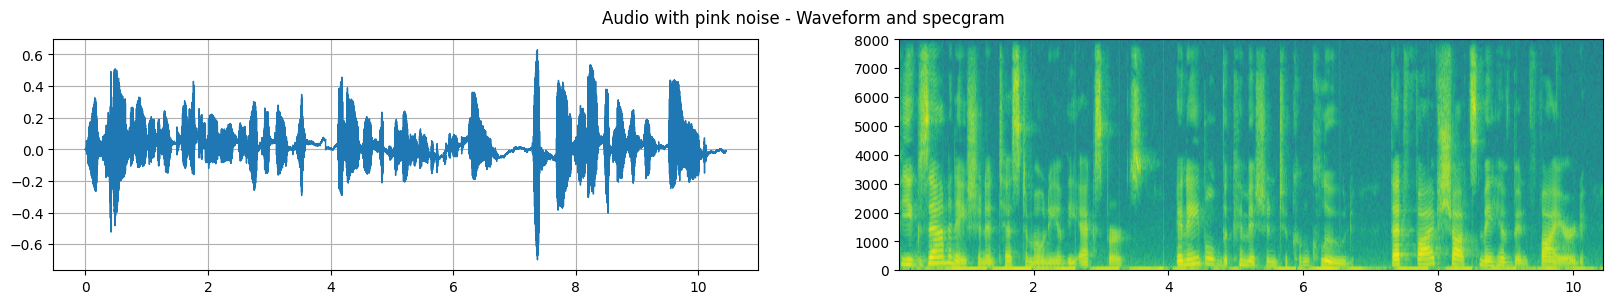

In [19]:
plot_waveform_and_specgram(pink_noised_audio, sample_rate=16000, title="Audio with pink noise")

In [20]:
play_audio(pink_noised_audio, sr)

In [21]:
result, message = detector.detect_watermark(pink_noised_audio, sample_rate=sr)
print(f"Detection Result with Pink Noise: {result}")

Detection Result with Pink Noise: 0.9870532155036926


#### Lowpass filter

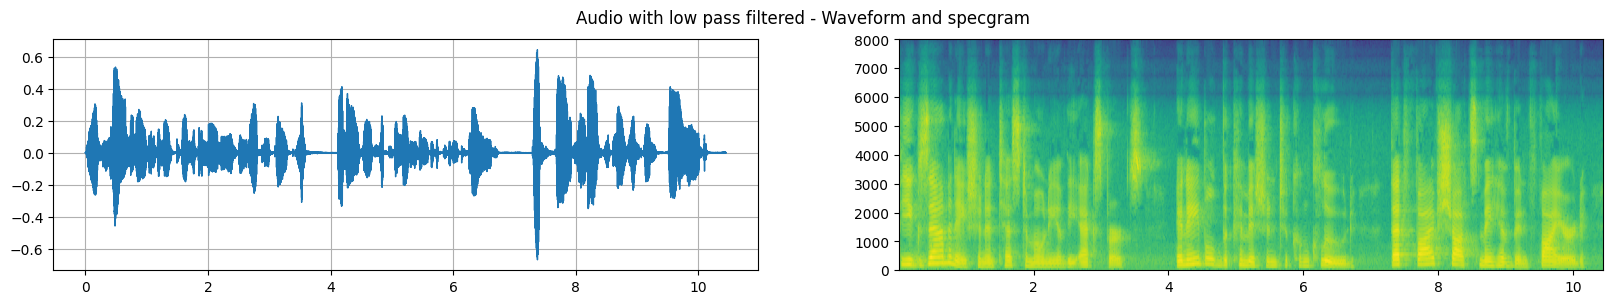

In [22]:
lowpass_filtered = af.lowpass_filter(watermarked_audio, cutoff_freq=5000, sample_rate=16000)
plot_waveform_and_specgram(lowpass_filtered, sample_rate=16000, title="Audio with low pass filtered")

In [23]:
play_audio(lowpass_filtered, sr)

In [24]:
result, message = detector.detect_watermark(lowpass_filtered, sample_rate=sr)
print(f"Detection Result with Lowpass Filter: {result}")

Detection Result with Lowpass Filter: 1.0


## Evaluate Audioseal with ASVspoof

In [9]:
import os

base_path = r'D:\dataset\DS_10283_3336\LA\LA'
audio_path = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
protocol_file = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols', 'ASVspoof2019.LA.cm.dev.trl.txt')

audio_files = []
labels = []
err_labels = []

with open(protocol_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1]
        label = parts[-1]
        filepath = os.path.join(audio_path, file_id + '.flac')
        if os.path.exists(filepath):
            audio_files.append(filepath)
            labels.append(1 if label == 'spoof' else 0)
            err_labels.append(0)

print(f"analysis completed. There are {len(audio_files)} audios in total")

analysis completed. There are 24844 audios in total


#### First, we calculate the false detection rate of non-watermarked audio being incorrectly classified as watermarked.

In [10]:
import torch
import torchaudio
from audioseal import AudioSeal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AudioSeal.load_generator("audioseal_wm_16bits").to(device)
detector = AudioSeal.load_detector(("audioseal_detector_16bits")).to(device)

def get_score(filepath):
    waveform, sr = torchaudio.load(filepath)
    with torch.no_grad():
        score, message = detector.detect_watermark(waveform.unsqueeze(0).to(device), sample_rate = sr, message_threshold=0.5)
    return float(score)

In [66]:
scores = []
for i, path in enumerate(audio_files):
    score = get_score(path)
    scores.append(score)
    if i % 100 == 0:
        print(f"Processed {i}/{len(audio_files)}")

Processed 0/24844
Processed 100/24844
Processed 200/24844
Processed 300/24844
Processed 400/24844
Processed 500/24844
Processed 600/24844
Processed 700/24844
Processed 800/24844
Processed 900/24844
Processed 1000/24844
Processed 1100/24844
Processed 1200/24844
Processed 1300/24844
Processed 1400/24844
Processed 1500/24844
Processed 1600/24844
Processed 1700/24844
Processed 1800/24844
Processed 1900/24844
Processed 2000/24844
Processed 2100/24844
Processed 2200/24844
Processed 2300/24844
Processed 2400/24844
Processed 2500/24844
Processed 2600/24844
Processed 2700/24844
Processed 2800/24844
Processed 2900/24844
Processed 3000/24844
Processed 3100/24844
Processed 3200/24844
Processed 3300/24844
Processed 3400/24844
Processed 3500/24844
Processed 3600/24844
Processed 3700/24844
Processed 3800/24844
Processed 3900/24844
Processed 4000/24844
Processed 4100/24844
Processed 4200/24844
Processed 4300/24844
Processed 4400/24844
Processed 4500/24844
Processed 4600/24844
Processed 4700/24844
Proc

In [108]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

threshold = 0.5
preds = [1 if s > threshold else 0 for s in scores]

acc = accuracy_score(err_labels, preds)
# tn, fp, fn, tp = confusion_matrix(y_true = err_labels, y_pred = preds, labels = [0,1]).ravel()
# tpr = tp / (tp + fn)
# fpr = fp / (fp + tn)
# auc = roc_auc_score(err_labels, scores)

print(f"\n🎯 评估结果（阈值 = {threshold}）")
print(f"不带水印音频的检测Accuracy: {acc:.3f}")
# print(f"TPR: {tpr:.3f}")
# print(f"FPR: {fpr:.3f}")
# print(f"AUC: {auc:.3f}")


🎯 评估结果（阈值 = 0.5）
不带水印音频的检测Accuracy: 1.000


#### Then, we embed watermarks into all audio samples in the test set and compute the detection rate of Audioseal.

In [18]:
def embed_mark(filepath):
    waveform, sr = torchaudio.load(filepath)
    waveform = waveform.unsqueeze(0).to(device)
    watermark = model.get_watermark(waveform, sample_rate=sr)
    watermarked_waveform = waveform + watermark
    return watermarked_waveform

In [17]:
watermarked_audio_list = []
for i, path in enumerate(audio_files):
    watermarked_audio = embed_mark(path)
    watermarked_audio_list.append(watermarked_audio)
    if i % 100 == 0:
        print(f"Processed {i}/{len(audio_files)}")

Processed 0/24844


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 19.57 GiB is allocated by PyTorch, and 134.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

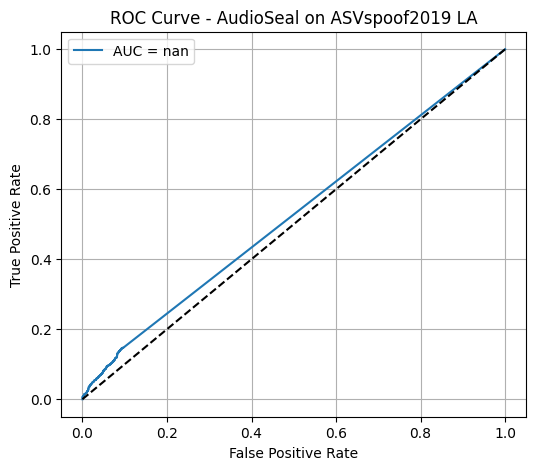

In [107]:
import matplotlib.pyplot as plt

fpr_vals, tpr_vals, _ = roc_curve(labels, scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr_vals, tpr_vals, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AudioSeal on ASVspoof2019 LA")
plt.legend()
plt.grid(True)
plt.show()